In [51]:
import os

import numpy as np
import pandas as pd

base_dir = "../Data"
base_csv_path = os.path.join(base_dir, 'base.csv')
assert os.path.exists(base_csv_path), f"base {base_csv_path} does not exist"

output_csv_path = os.path.join(base_dir, 'base_cleaned.csv')
df = pd.read_csv(base_csv_path)

/var/folders/k_/917q0lsn2g199rm9y4s8jy5h0000gn/T/ipykernel_70619/2691778949.py:11: DtypeWarning: Columns (2,64,91,94,97,106,108,109,110,111,112,114,116,119,120,122,127,139,142,143,144,145,152,153,154,155,156,157,159,160,161,163,164,165,169,170,171,172,175,178,179,180,187,189,215,216,217,218,219,317,318) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(base_csv_path)


In [52]:
# List number of columns in base.csv
print(f"Number of columns in base.csv: {len(df.columns)}")

Number of columns in base.csv: 320


## Feature selection

In [53]:
# Replace "ethnicity" has been replaced with ethcat variable
desired_columns = ['thoracic_dgn', 'num_prev_tx', 'tah', 'vas', 'onvent', 'icu', 'inotropic', 'gender', 'abo',
                   'wgt_kg_tcr', 'hgt_cm_tcr', 'education', 'ecmo_tcr', 'iabp_tcr', 'inotropes_tcr', 'func_stat_tcr',
                   'diab', 'dial_ty_tcr', 'cereb_vasc', 'malig_tcr', 'most_rcnt_creat', 'tot_serum_album',
                   'hemo_co_tcr', 'cig_use', 'prior_card_surg_tcr', 'histry_cig_old', 'init_stat', 'init_creat',
                   'init_age', 'ethcat', 'init_hgt_cm_calc', 'init_wgt_kg_calc', 'ventilator_tcr', 'lvad_at_listing',
                   'rvad_at_listing', 'work_income_tcr', 'tx_date', 'init_date']

df = df[desired_columns]

In [54]:
# Remove all init_age under 18
pre_len = len(df.index)
df = df[df['init_age'] >= 18]
post_len = len(df.index)
print(
    f"Removed patients under 18: {pre_len - post_len}/{pre_len} ({(pre_len - post_len) / pre_len * 100:.2f}% removed)")

Removed patients under 18: 16205/120264 (13.47% removed)


## Encoding

In [55]:
print(f'Number of rows with value 6 in ethcat before replacing values: {len(df[df["ethcat"] == 6])}')

#1=1 (White), 2=2 (Black), 4=4 (Hispanic), 5=5 (Asian),6=6 (tidigare Amer Ind/Alaskan, kodas nu om till Other) 7=6 (tidigare Native Hawaiian, nu Other) 9=6 (tidigare Multiracial, nu Other)
df['ethcat'] = df['ethcat'].replace([7, 9], 6)
df['ethcat'] = df['ethcat'].replace([996, 998], np.nan)
print(f'Number of rows with value 6 in ethcat after replacing values: {len(df[df["ethcat"] == 6])}')

Number of rows with value 6 in ethcat before replacing values: 357
Number of rows with value 6 in ethcat after replacing values: 999


In [56]:
# Encode education

df['education'] = df['education'].replace([2, 3], 1)  # High school or less
df['education'] = df['education'].replace([4], 2)  # Some college
df['education'] = df['education'].replace([5, 6], 3)  # College or graduate
df['education'] = df['education'].replace([996, 998], np.nan)

In [57]:
# TODO: Recode num_prev_tx > 3 to 3
pre_len = len(df.index)
df = df[df['num_prev_tx'].isna() | df['num_prev_tx'].between(0, 3)]
post_len = len(df.index)
print(
    f"Removed patients with num_prev_tx > 3: {pre_len - post_len}/{pre_len} ({(pre_len - post_len) / pre_len * 100:.2f}% removed)")

Removed patients with num_prev_tx > 3: 11/104059 (0.01% removed)


In [58]:
# Encode init_stat: label define status 1 "Status 1A" 2 "Status 1B" 3 "Status 2" 4 "Temp inactive"

df["init_stat"] = df["init_stat"].replace([2010, 2110, 2120, 2130, 2090], 1)
df["init_stat"] = df["init_stat"].replace([2020, 2140], 2)
df["init_stat"] = df["init_stat"].replace([2030, 2150, 2160], 3)
df["init_stat"] = df["init_stat"].replace([2999], 4)

In [59]:
# Encode thoracic_dgn: label define diag 1 "Cardiomyopathy" 2 "CAD" 3 "Valvular heart disease" 4 "Graft failure" 5 "Congenital" 7 "Other"
df["thoracic_dgn"] = df["thoracic_dgn"].replace(range(1000, 1099 + 1), 1)
df["thoracic_dgn"] = df["thoracic_dgn"].replace([1201], 1)
df["thoracic_dgn"] = df["thoracic_dgn"].replace([1007, 1200], 2)
df["thoracic_dgn"] = df["thoracic_dgn"].replace([1202], 3)
df["thoracic_dgn"] = df["thoracic_dgn"].replace(range(1100, 1199 + 1), 4)
df["thoracic_dgn"] = df["thoracic_dgn"].replace(range(1203, 1207 + 1), 5)
df["thoracic_dgn"] = df["thoracic_dgn"].replace([1208, 1209, 999, 1497, 1498], 7)
df["thoracic_dgn"] = df["thoracic_dgn"].replace([1998], np.nan)
df["thoracic_dgn"] = df["thoracic_dgn"].replace([1999], np.nan)

# Remove all patients with thoracic_dgn that is not nan or 1-7
# The prevalence is too low for the other values
pre_len = len(df.index)
df = df[df['thoracic_dgn'].isna() | df['thoracic_dgn'].between(1, 7)]
post_len = len(df.index)
print(
    f"Removed patients with thoracic_dgn that is not nan or 1-7: {pre_len - post_len}/{pre_len} ({(pre_len - post_len) / pre_len * 100:.2f}% removed)")


Removed patients with thoracic_dgn that is not nan or 1-7: 56/104048 (0.05% removed)


In [60]:
df["func_stat_tcr"] = df["func_stat_tcr"].replace([2010, 2020, 2030, 2040, 2050, 4010, 4020, 4030, 4040, 4050], 3)
df["func_stat_tcr"] = df["func_stat_tcr"].replace([2060, 2070, 2080, 4060, 4070, 4080], 2)
df["func_stat_tcr"] = df["func_stat_tcr"].replace([2090, 2100, 4090, 4100], 1)
df["func_stat_tcr"] = df["func_stat_tcr"].replace([996, 998], np.nan)

In [61]:
df["abo"] = df["abo"].replace(["A", "A1", "A2"], 1)
df["abo"] = df["abo"].replace(["B"], 2)
df["abo"] = df["abo"].replace(["AB", "A1B", "A2B"], 3)
df["abo"] = df["abo"].replace(["O"], 4)

In [62]:
df["diab"] = df["diab"].replace([996, 998], np.nan)
df["dial_ty_tcr"] = df["dial_ty_tcr"].replace([996, 998, 999], np.nan)
# df["academic_level_tcr"] = df["academic_level_tcr"].replace([996, 998], np.nan)


## Cleaning

In [63]:
# Remove rows with no transplant date
pre_len = len(df.index)
df = df[df['tx_date'].notna()]
post_len = len(df.index)

print(f"Filtered to only transplanted patients: {post_len}/{pre_len} ({post_len / pre_len * 100:.2f}% remaining)")

# Compute the time to transplant (waitlist time -> wl_time)
df['wl_time'] = (
        pd.to_datetime(df['tx_date'], format='%d%b%Y') - pd.to_datetime(df['init_date'], format='%d%b%Y')).dt.days
df = df.drop(columns=['tx_date', 'init_date'])
print(f"Median waitlist time: {df['wl_time'].median():.2f} days")


Filtered to only transplanted patients: 66839/103992 (64.27% remaining)
Median waitlist time: 87.00 days


In [64]:
# Remove columns where all values are missing
pre_len = len(df.columns)
df = df.dropna(axis=1, how='all')
post_len = len(df.columns)
print(
    f"Removed columns with all missing values: {pre_len - post_len}/{pre_len} ({(pre_len - post_len) / pre_len * 100:.2f}% removed)")

# Remove columns where there is no variance
pre_len = len(df.columns)
df = df.loc[:, df.nunique() != 1]
post_len = len(df.columns)
print(
    f"Removed columns with no variance: {pre_len - post_len}/{pre_len} ({(pre_len - post_len) / pre_len * 100:.2f}% removed)")


Removed columns with all missing values: 1/37 (2.70% removed)
Removed columns with no variance: 2/36 (5.56% removed)


In [65]:
# Remove weights under 30kg and over 250kg
pre_len = len(df.index)
df = df[df['init_wgt_kg_calc'] >= 30]
df = df[df['wgt_kg_tcr'] >= 30]
df = df[df['init_wgt_kg_calc'] <= 250]
df = df[df['wgt_kg_tcr'] <= 250]
post_len = len(df.index)
print(
    f"Removed patients with weight under 30kg or over 250kg: {pre_len - post_len}/{pre_len} ({(pre_len - post_len) / pre_len * 100:.2f}% removed)")

# Remove heights under 140cm and over 210cm
pre_len = len(df.index)
df = df[df['init_hgt_cm_calc'] >= 140]
df = df[df['hgt_cm_tcr'] >= 140]
df = df[df['init_hgt_cm_calc'] <= 210]
df = df[df['hgt_cm_tcr'] <= 210]
post_len = len(df.index)
print(
    f"Removed patients with height under 140cm or over 210cm: {pre_len - post_len}/{pre_len} ({(pre_len - post_len) / pre_len * 100:.2f}% removed)")

# Remove patients with creatinine under 0.3 and over 20 - keep missing values
pre_len = len(df.index)
df = df[(df['most_rcnt_creat'] >= 0.3) & (df['most_rcnt_creat'] <= 20) | pd.isnull(df['most_rcnt_creat'])]
post_len = len(df.index)
print(
    f"Removed patients with creatinine under 0.3 or over 20: {pre_len - post_len}/{pre_len} ({(pre_len - post_len) / pre_len * 100:.2f}% removed)")

# Remove patients with albumin under 2 and over 7.5
pre_len = len(df.index)
df = df[(df['tot_serum_album'] >= 2) & (df['tot_serum_album'] <= 7.5) | pd.isnull(df['tot_serum_album'])]
post_len = len(df.index)
print(
    f"Removed patients with albumin under 2 or over 7.5: {pre_len - post_len}/{pre_len} ({(pre_len - post_len) / pre_len * 100:.2f}% removed)")

# Remove cardiac output under 1 and over 20
pre_len = len(df.index)
df = df[(df['hemo_co_tcr'] >= 1) & (df['hemo_co_tcr'] <= 15) | pd.isnull(df['hemo_co_tcr'])]
post_len = len(df.index)

print(
    f"Removed patients with cardiac output under 1 or over 20: {pre_len - post_len}/{pre_len} ({(pre_len - post_len) / pre_len * 100:.2f}% removed)")

Removed patients with weight under 30kg or over 250kg: 842/66839 (1.26% removed)
Removed patients with height under 140cm or over 210cm: 435/65997 (0.66% removed)
Removed patients with creatinine under 0.3 or over 20: 18/65562 (0.03% removed)
Removed patients with albumin under 2 or over 7.5: 464/65544 (0.71% removed)
Removed patients with cardiac output under 1 or over 20: 13/65080 (0.02% removed)


In [66]:
# Find the categorical columns using nunique
categorical_columns = df.nunique()[df.nunique() < 20].index.tolist()
categorical_column_indexes = [df.columns.get_loc(c) for c in categorical_columns if c in df]

# Print the number of categorical columns
print(f"Number of categorical columns: {len(categorical_columns)}")
print(f"Categorical columns: {categorical_columns}")

# print unique values in each categorical column and their frequency
for col in categorical_columns:
    print(f"{col}: {df[col].unique()}")
    print(f"{df[col].value_counts()}")

Number of categorical columns: 25
Categorical columns: ['thoracic_dgn', 'num_prev_tx', 'tah', 'vas', 'onvent', 'icu', 'inotropic', 'gender', 'abo', 'education', 'ecmo_tcr', 'iabp_tcr', 'inotropes_tcr', 'func_stat_tcr', 'diab', 'dial_ty_tcr', 'cereb_vasc', 'malig_tcr', 'cig_use', 'prior_card_surg_tcr', 'histry_cig_old', 'init_stat', 'ethcat', 'ventilator_tcr', 'work_income_tcr']
thoracic_dgn: [ 1. nan  4.  2.  7.  3.  5.]
1.0    47377
2.0     5318
4.0     1690
5.0     1429
3.0     1077
7.0      890
Name: thoracic_dgn, dtype: int64
num_prev_tx: [0 1 2 3]
0    63092
1     1881
2       80
3       14
Name: num_prev_tx, dtype: int64
tah: [nan 'N' 'Y']
N    19603
Y       83
Name: tah, dtype: int64
vas: [nan 'N' 'Y']
N    18789
Y      897
Name: vas, dtype: int64
onvent: [nan 'N' 'Y']
N    19032
Y      654
Name: onvent, dtype: int64
icu: [nan 'Y' 'N']
Y    11172
N     8545
Name: icu, dtype: int64
inotropic: [nan 'Y' 'N']
Y    5263
N    3569
Name: inotropic, dtype: int64
gender: ['M' 'F']
M    4

In [67]:
# print all categorical columns and their amount of unique values
for col in categorical_columns:
    print(f"{col}: {len(df[col].unique())}")

# print all min and max values for each column
numerical_columns = [col for col in df.columns if col not in categorical_columns]
for col in numerical_columns:
    amount_missing = df[col].isna().sum()
    print(f"{col}: {df[col].min()} - {df[col].max()} ({amount_missing} missing)")

for col in df.columns:
    try:
        print(f"{col} ({df[col].isna().sum()} missing) ({df[col].isna().sum() / len(df[col]) * 100:.2f}%)")
    except Exception as e:
        print(col)


thoracic_dgn: 7
num_prev_tx: 4
tah: 3
vas: 3
onvent: 3
icu: 3
inotropic: 3
gender: 2
abo: 4
education: 4
ecmo_tcr: 2
iabp_tcr: 2
inotropes_tcr: 2
func_stat_tcr: 4
diab: 6
dial_ty_tcr: 4
cereb_vasc: 4
malig_tcr: 4
cig_use: 3
prior_card_surg_tcr: 4
histry_cig_old: 4
init_stat: 5
ethcat: 6
ventilator_tcr: 2
work_income_tcr: 4
wgt_kg_tcr: 31.2 - 200.0 (0 missing)
hgt_cm_tcr: 140.0 - 210.0 (0 missing)
most_rcnt_creat: 0.3 - 19.88 (22752 missing)
tot_serum_album: 2.0 - 7.5 (39397 missing)
hemo_co_tcr: 1.0 - 15.0 (15923 missing)
init_age: 18.0 - 78.0 (0 missing)
init_hgt_cm_calc: 140.0 - 210.0 (0 missing)
init_wgt_kg_calc: 31.2 - 200.0 (0 missing)
wl_time: 0 - 6412 (0 missing)
thoracic_dgn (7286 missing) (11.20%)
num_prev_tx (0 missing) (0.00%)
tah (45381 missing) (69.75%)
vas (45381 missing) (69.75%)
onvent (45381 missing) (69.75%)
icu (45350 missing) (69.70%)
inotropic (56235 missing) (86.43%)
gender (0 missing) (0.00%)
abo (0 missing) (0.00%)
wgt_kg_tcr (0 missing) (0.00%)
hgt_cm_tcr (0 mi

In [68]:
df.to_csv(output_csv_path, index=False)

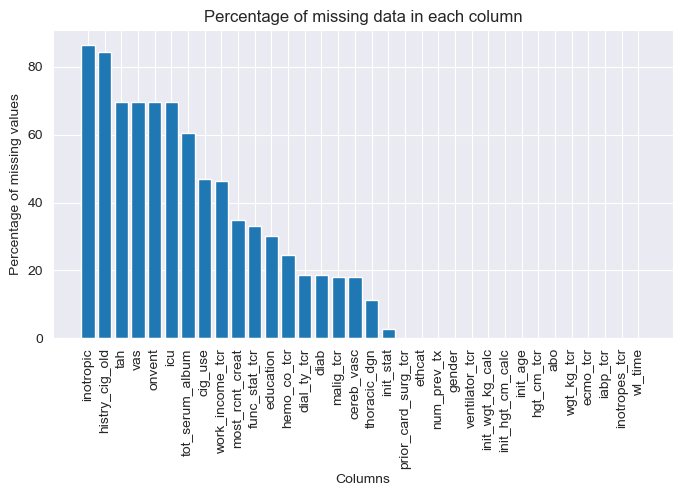

In [69]:
from matplotlib import pyplot as plt

# make a table with the amount of missing values in each column
miss_df = df.isnull().sum(axis=0).reset_index()
miss_df.columns = ['column_name', 'missing_values_count']
miss_df = miss_df.sort_values(by='missing_values_count')

# calculate the percentage of missing values in each column
miss_df['missing_values_%'] = miss_df['missing_values_count'] / len(df) * 100

# plot the percentage of missing values in each column
missing_values_table = miss_df.sort_values(by='missing_values_%', ascending=False)
plt.figure(figsize=(8, 4))
plt.bar(missing_values_table['column_name'], missing_values_table['missing_values_%'])
plt.xticks(rotation=90)
plt.ylabel('Percentage of missing values')
plt.xlabel('Columns')
plt.title('Percentage of missing data in each column')
plt.show()
